In [320]:
## Import and data processing

import json
import pandas as pd
import numpy as np


with open('sreality/output.json') as data_file: data = json.load(data_file)
    
df = pd.io.json.json_normalize(data)

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 30)

df.shape

(180, 12)

In [321]:
df.head(3)

,id,location,navic,novostavba,plocha,podlazi,price,stavba,stitky,url,velikost,vlastnictvi
0,379335004,"K Červenému dvoru, Praha 10",",garaz,vytah",True,67,1. podlaží z celkem 5,7 805 088 Kč,cihlova,"Terasa,Garáž,Nevybavený,Sp...",2+kk/praha--k-cervenemu-dv...,2+kk,osobni
1,2096754780,"Kostnické náměstí, Praha 3...","sklep,vytah",True,135,4. podlaží z celkem 7,10 000 000 Kč,cihlova,Nevybavený,4+kk/praha-zizkov-kostnick...,4+kk,osobni
2,1986011484,"Vysočanská, Praha 9 - Stří...","lodzie,vytah",False,80,9. podlaží z celkem 10,5 120 000 Kč,panelova,"Lodžie,Panelová,Částečně v...",3+kk/praha-strizkov-vysoca...,3+kk,osobni


In [322]:
df.index = df['id'].apply(pd.to_numeric)
del df['id']

In [323]:
df.ix[1986011484]

location       Vysočanská, Praha 9 - Stří...
navic                           lodzie,vytah
novostavba                             False
plocha                                    80
podlazi               9. podlaží z celkem 10
price                           5 120 000 Kč
stavba                              panelova
stitky         Lodžie,Panelová,Částečně v...
url            3+kk/praha-strizkov-vysoca...
velikost                                3+kk
vlastnictvi                           osobni
Name: 1986011484, dtype: object

In [324]:
# need to add https://www.sreality.cz/detail/prodej/byt/ to url
df.ix[1986011484][{'url'}]

url    3+kk/praha-strizkov-vysoca...
Name: 1986011484, dtype: object

In [325]:
pd.options.display.max_colwidth = 100
print df.ix[1986011484][{'url'}]
pd.options.display.max_colwidth = 30

url    3+kk/praha-strizkov-vysocanska/1986011484
Name: 1986011484, dtype: object


In [326]:
# Column names:
df.columns

Index([u'location', u'navic', u'novostavba', u'plocha', u'podlazi', u'price',
       u'stavba', u'stitky', u'url', u'velikost', u'vlastnictvi'],
      dtype='object')

In [327]:
df['location'].value_counts()[:5]

Praha 8                            5
Sokolovská, Praha 8 - Karlín       4
Křížová, Praha 5 - Smíchov         3
Žitomírská, Praha 10 - Vršovice    3
Hnězdenská, Praha 8 - Troja        2
Name: location, dtype: int64

In [328]:
df['vlastnictvi'].value_counts()

osobni        161
druzstevni     19
Name: vlastnictvi, dtype: int64

In [329]:
df[df['price'] == u'Info o ceně u RK'][:3]

,location,navic,novostavba,plocha,podlazi,price,stavba,stitky,url,velikost,vlastnictvi
id,,,,,,,,,,,
2499227996,"Nechvílova, Praha 4 - Chodov",",vytah",False,69,8. podlaží z celkem 14 vče...,Info o ceně u RK,panelova,"Družstevní,Panelová",3+kk/praha-chodov-nechvilo...,3+kk,druzstevni
4039323996,"Nuselská, Praha 4 - Michle","sklep,vytah",False,55,3. podlaží z celkem 5,Info o ceně u RK,cihlova,Tramvaj 2 min. pěšky,2+1/praha-michle-nuselska/...,2+1,osobni
563163484,"Pařížská, Praha 1 - Josefov","balkon,vytah",False,71,3. podlaží z celkem 6,Info o ceně u RK,cihlova,"Po rekonstrukci,Balkon,Poš...",2+kk/praha-josefov-parizsk...,2+kk,osobni


In [330]:
# Removing our 'priceless' offers
df = df[df['price'] != u'Info o ceně u RK']

In [331]:
df['price'] = df['price'].map(lambda x: x[:x.find(u' Kč')].replace(' ',''))

In [332]:
# converting price
df['price'] = pd.to_numeric(df['price'], errors='coerce')

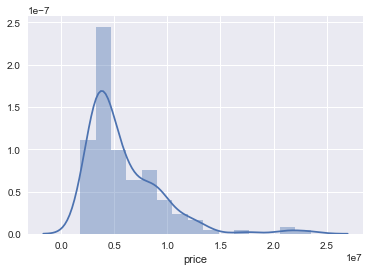

In [333]:
%matplotlib inline
import seaborn as sns
# destribution
sns.distplot(df['price']);

In [334]:
# overall info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175 entries, 379335004 to 1905336668
Data columns (total 11 columns):
location       175 non-null object
navic          175 non-null object
novostavba     175 non-null object
plocha         153 non-null object
podlazi        153 non-null object
price          175 non-null int64
stavba         175 non-null object
stitky         175 non-null object
url            175 non-null object
velikost       175 non-null object
vlastnictvi    175 non-null object
dtypes: int64(1), object(10)
memory usage: 16.4+ KB


## Filling missing fields

### Užitná plocha

In [335]:
df['plocha'] = pd.to_numeric(df['plocha'], errors='coerce')

### Lodžie, Novostavba, sklep, parkovani

In [336]:
def contains_converter(mapping, param):
    for i in mapping:        
        if param.find(i) > -1:
            return mapping[i]
    return ''
balcony_mapping = {
        u'balkon':u'balkon',
        u'lodzie':u'lodzie',
        u'terasa':u'terasa'    
    }

df['sklep'] = df['navic'].str.contains('sklep')
df['parkovani'] = df['navic'].str.contains('parkovani')
df['vytah'] = df['navic'].str.contains('vytah')
df['balkon'] = df['navic'].map(lambda x: contains_converter(balcony_mapping, x))
df.head()

,location,navic,novostavba,plocha,podlazi,price,stavba,stitky,url,velikost,vlastnictvi,sklep,parkovani,vytah,balkon
id,,,,,,,,,,,,,,,
379335004,"K Červenému dvoru, Praha 10",",garaz,vytah",True,67.0,1. podlaží z celkem 5,7805088,cihlova,"Terasa,Garáž,Nevybavený,Sp...",2+kk/praha--k-cervenemu-dv...,2+kk,osobni,False,False,True,
2096754780,"Kostnické náměstí, Praha 3...","sklep,vytah",True,135.0,4. podlaží z celkem 7,10000000,cihlova,Nevybavený,4+kk/praha-zizkov-kostnick...,4+kk,osobni,True,False,True,
1986011484,"Vysočanská, Praha 9 - Stří...","lodzie,vytah",False,80.0,9. podlaží z celkem 10,5120000,panelova,"Lodžie,Panelová,Částečně v...",3+kk/praha-strizkov-vysoca...,3+kk,osobni,False,False,True,lodzie
1830232412,"Hnězdenská, Praha 8 - Troja",,True,88.0,10. podlaží z celkem 17,5990000,ostatni,Částečně vybavený,3+kk/praha-troja-hnezdensk...,3+kk,osobni,False,False,False,
543605084,"Karlovo náměstí, Praha 2 -...",vytah,False,109.0,4. podlaží z celkem 5,10200000,cihlova,Nevybavený,3+kk/praha-nove-mesto-karl...,3+kk,osobni,False,False,True,


### metro

In [345]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175 entries, 379335004 to 1905336668
Data columns (total 15 columns):
location       175 non-null object
navic          175 non-null object
novostavba     175 non-null object
plocha         153 non-null float64
podlazi        153 non-null object
price          175 non-null int64
stavba         175 non-null object
stitky         175 non-null object
url            175 non-null object
velikost       175 non-null object
vlastnictvi    175 non-null object
sklep          175 non-null bool
parkovani      175 non-null bool
vytah          175 non-null bool
balkon         175 non-null object
dtypes: bool(3), float64(1), int64(1), object(10)
memory usage: 18.3+ KB


## Обучение модели

In [337]:
# Добавим несколько методов для создания енкодеров:

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Добавляет в DataFrame df новый столбец с именем column_name+'_le', содержащий номера категорий, 
# соответствующие столбцу column_name. Исходный столбец column_name удаляется
#
def encode_with_LabelEncoder(df, column_name):
    label_encoder = LabelEncoder()
    label_encoder.fit(df[column_name])
    df[column_name+'_le'] = label_encoder.transform(df[column_name])
    df.drop([column_name], axis=1, inplace=True)
    return label_encoder

# Кодирование с использованием ранее созданного LabelEncoder
#
def encode_with_existing_LabelEncoder(df, column_name, label_encoder):
    df[column_name+'_le'] = label_encoder.transform(df[column_name])
    df.drop([column_name], axis=1, inplace=True)

# Вначале кодирует столбец column_name при помощи LabelEncoder, потом добавляет в DataFrame df новые столбцы 
# с именами column_name=<категория_i>. Столбцы column_name и column_name+'_le' удаляются
# Usage: df, label_encoder = encode_with_OneHotEncoder_and_delete_column(df, column_name)
#
def encode_with_OneHotEncoder_and_delete_column(df, column_name):
    le_encoder = encode_with_LabelEncoder(df, column_name)
    return perform_dummy_coding_and_delete_column(df, column_name, le_encoder), le_encoder

# То же, что предыдущий метод, но при помощи уже существующего LabelEncoder
#
def encode_with_OneHotEncoder_using_existing_LabelEncoder_and_delete_column(df, column_name, le_encoder):
    encode_with_existing_LabelEncoder(df, column_name, le_encoder)
    return perform_dummy_coding_and_delete_column(df, column_name, le_encoder)

# Реализует Dummy-кодирование
#
def perform_dummy_coding_and_delete_column(df, column_name, le_encoder):
    oh_encoder = OneHotEncoder(sparse=False)
    oh_features = oh_encoder.fit_transform(df[column_name+'_le'].values.reshape(-1,1))
    ohe_columns=[column_name + '=' + le_encoder.classes_[i] for i in range(oh_features.shape[1])]

    df.drop([column_name+'_le'], axis=1, inplace=True)

    df_with_features = pd.DataFrame(oh_features, columns=ohe_columns)
    df_with_features.index = df.index
    return pd.concat([df, df_with_features], axis=1)

In [338]:
# Кодируем категориальные признаки при помощи Label и Dummy-кодирования:
#
X = df.drop({'price','navic','stitky','url','podlazi'}, axis=1)
Y = df['price']
novostavba_le_converter = encode_with_LabelEncoder(X,'novostavba')
X, balcony_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,'balkon')
X, stavba_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,'stavba')
X, velikost_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,'velikost')
X, vlastnictvi_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,'vlastnictvi')
X, location_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,'location')
sklep_le_encoder = encode_with_LabelEncoder(X,'sklep')
parkovani_le_encoder = encode_with_LabelEncoder(X,'parkovani')
vytah_le_encoder = encode_with_LabelEncoder(X,'vytah')
X.head()


,plocha,novostavba_le,balkon=,balkon=balkon,balkon=lodzie,balkon=terasa,stavba=cihlova,stavba=ostatni,stavba=panelova,velikost=1+1,velikost=1+kk,velikost=2+1,velikost=2+kk,velikost=3+1,velikost=3+kk,velikost=4+1,velikost=4+kk,velikost=5+1,velikost=5+kk,vlastnictvi=druzstevni,vlastnictvi=osobni,"location=5. května, Praha 4 - Nusle","location=Amforová, Praha 5 - Stodůlky","location=Amurská, Praha 10 - Vršovice","location=Baranova, Praha 3 - Žižkov","location=Bellušova, Praha 5 - Stodůlky","location=Biskupcova, Praha 3 - Žižkov","location=Boloňská, Praha 10 - Horní Měcholupy","location=Borovanského, Praha - Stodůlky","location=Chmelová, Praha - Záběhlice","location=Ciolkovského, Praha 6 - Ruzyně","location=Dobevská, Praha 4 - Kamýk","location=Doubravická, Praha 4 - Chodov","location=Družstevní ochoz, Praha 4 - Nusle","location=Eliášova, Praha 6 - Bubeneč","location=Hellichova, Praha 1 - Malá Strana","location=Hnězdenská, Praha 8 - Troja","location=Horní, Praha 4 - Nusle","location=Hradeckých, Praha 4 - Nusle","location=Husova, Praha 1 - Staré Město","location=Irská, Praha 6 - Vokovice","location=Jandova, Praha 9 - Vysočany","location=Jaromírova, Praha 2 - Nusle","location=Jaselská, Praha 6 - Bubeneč","location=Jeremenkova, Praha 4 - Podolí","location=Jeronýmova, Praha 3 - Žižkov","location=Jesenická, Praha 10 - Záběhlice","location=Jeřábkova, Praha 4 - Chodov","location=Jičínská, Praha 3 - Žižkov","location=Jugoslávských partyzánů, Praha 6 - Bubeneč","location=Junácká, Praha 6 - Břevnov","location=Jílovská, Praha 4 - Lhotka","location=K Dálnici, Praha 10 - Uhříněves","location=K Horoměřicům, Praha 6 - Suchdol","location=K Červenému dvoru, Praha 10","location=K Červenému dvoru, Praha 3 - Strašnice","location=Kabešova, Praha - Vysočany","location=Karlovo náměstí, Praha 2 - Nové Město","location=Ke Koulce, Praha 5 - Smíchov","location=Ke Škole, Praha 4 - Chodov","location=Kolbenova, Praha","location=Kolbenova, Praha 9 - Vysočany","location=Korunovační, Praha 7 - Bubeneč","location=Kostnické náměstí, Praha 3 - Žižkov","location=Kukelská, Praha - Hloubětín","location=Kukelská, Praha 9 - Hloubětín","location=Kurta Konráda, Praha 9 - Libeň","location=Květinková, Praha 3 - Žižkov","location=Kytlická, Praha 9 - Prosek","location=Křížová, Praha 5 - Smíchov","location=Lannova, Praha 1 - Nové Město","location=Laurinova, Praha - Stodůlky","location=Levského, Praha 4 - Modřany","location=Libická, Praha - Vinohrady","location=Lihovarská, Praha 9 - Libeň","location=Limuzská, Praha 10 - Malešice","location=Lípová, Praha 2 - Nové Město","location=Makovského, Praha 6 - Řepy","location=Masarykovo nábřeží, Praha 2 - Nové Město","location=Mařákova, Praha 6 - Dejvice","location=Meteorologická, Praha 4 - Libuš","location=Mezi školami, Praha 5 - Stodůlky","location=Mezilehlá, Praha 9 - Hrdlořezy","location=Mečíková, Praha 10 - Záběhlice","location=Michelangelova, Praha 10 - Strašnice","location=Mikulova, Praha 4 - Chodov","location=Mánesova, Praha 2 - Vinohrady","location=Měšínská, Praha 9 - Újezd nad Lesy","location=Na Dolinách, Praha 4 - Nusle","location=Na Harfě, Praha 9 - Vysočany","location=Na Jezerce, Praha - Nusle","location=Na Jezerce, Praha 4 - Nusle","location=Na Pankráci, Praha 4 - Nusle","location=Na Vysočanských vinicích, Praha 9 - Vysočany","location=Na Výrovně, Praha 5 - Stodůlky","location=Nad Smetankou, Praha 9 - Hrdlořezy","location=Nad Vavrouškou, Praha 8 - Troja","location=Nademlejnská, Praha 9 - Hloubětín","location=Novodvorská, Praha 4 - Braník","location=Novovysočanská, Praha 9 - Vysočany","location=Novákových, Praha 8 - Libeň","location=Ocelářská, Praha 9 - Vysočany","location=Olbrachtova, Praha 4 - Krč","location=Oravská, Praha - Strašnice","location=Orelská, Praha 10 - Vršovice","location=Ortenovo náměstí, Praha 7 - Holešovice","location=Paťanka, Praha 6 - Dejvice","location=Pelušková, Praha - Kyje","location=Petržílkova, Praha 5 - Stodůlky","location=Pečárková, Praha 10 - Pitkovice","location=Pitterova, Praha 3 - Žižkov","locat

In [344]:
X.shape
X[X['plocha'] > 100]
X

,plocha,novostavba_le,balkon=,balkon=balkon,balkon=lodzie,balkon=terasa,stavba=cihlova,stavba=ostatni,stavba=panelova,velikost=1+1,velikost=1+kk,velikost=2+1,velikost=2+kk,velikost=3+1,velikost=3+kk,velikost=4+1,velikost=4+kk,velikost=5+1,velikost=5+kk,vlastnictvi=druzstevni,vlastnictvi=osobni,"location=5. května, Praha 4 - Nusle","location=Amforová, Praha 5 - Stodůlky","location=Amurská, Praha 10 - Vršovice","location=Baranova, Praha 3 - Žižkov","location=Bellušova, Praha 5 - Stodůlky","location=Biskupcova, Praha 3 - Žižkov","location=Boloňská, Praha 10 - Horní Měcholupy","location=Borovanského, Praha - Stodůlky","location=Chmelová, Praha - Záběhlice","location=Ciolkovského, Praha 6 - Ruzyně","location=Dobevská, Praha 4 - Kamýk","location=Doubravická, Praha 4 - Chodov","location=Družstevní ochoz, Praha 4 - Nusle","location=Eliášova, Praha 6 - Bubeneč","location=Hellichova, Praha 1 - Malá Strana","location=Hnězdenská, Praha 8 - Troja","location=Horní, Praha 4 - Nusle","location=Hradeckých, Praha 4 - Nusle","location=Husova, Praha 1 - Staré Město","location=Irská, Praha 6 - Vokovice","location=Jandova, Praha 9 - Vysočany","location=Jaromírova, Praha 2 - Nusle","location=Jaselská, Praha 6 - Bubeneč","location=Jeremenkova, Praha 4 - Podolí","location=Jeronýmova, Praha 3 - Žižkov","location=Jesenická, Praha 10 - Záběhlice","location=Jeřábkova, Praha 4 - Chodov","location=Jičínská, Praha 3 - Žižkov","location=Jugoslávských partyzánů, Praha 6 - Bubeneč","location=Junácká, Praha 6 - Břevnov","location=Jílovská, Praha 4 - Lhotka","location=K Dálnici, Praha 10 - Uhříněves","location=K Horoměřicům, Praha 6 - Suchdol","location=K Červenému dvoru, Praha 10","location=K Červenému dvoru, Praha 3 - Strašnice","location=Kabešova, Praha - Vysočany","location=Karlovo náměstí, Praha 2 - Nové Město","location=Ke Koulce, Praha 5 - Smíchov","location=Ke Škole, Praha 4 - Chodov","location=Kolbenova, Praha","location=Kolbenova, Praha 9 - Vysočany","location=Korunovační, Praha 7 - Bubeneč","location=Kostnické náměstí, Praha 3 - Žižkov","location=Kukelská, Praha - Hloubětín","location=Kukelská, Praha 9 - Hloubětín","location=Kurta Konráda, Praha 9 - Libeň","location=Květinková, Praha 3 - Žižkov","location=Kytlická, Praha 9 - Prosek","location=Křížová, Praha 5 - Smíchov","location=Lannova, Praha 1 - Nové Město","location=Laurinova, Praha - Stodůlky","location=Levského, Praha 4 - Modřany","location=Libická, Praha - Vinohrady","location=Lihovarská, Praha 9 - Libeň","location=Limuzská, Praha 10 - Malešice","location=Lípová, Praha 2 - Nové Město","location=Makovského, Praha 6 - Řepy","location=Masarykovo nábřeží, Praha 2 - Nové Město","location=Mařákova, Praha 6 - Dejvice","location=Meteorologická, Praha 4 - Libuš","location=Mezi školami, Praha 5 - Stodůlky","location=Mezilehlá, Praha 9 - Hrdlořezy","location=Mečíková, Praha 10 - Záběhlice","location=Michelangelova, Praha 10 - Strašnice","location=Mikulova, Praha 4 - Chodov","location=Mánesova, Praha 2 - Vinohrady","location=Měšínská, Praha 9 - Újezd nad Lesy","location=Na Dolinách, Praha 4 - Nusle","location=Na Harfě, Praha 9 - Vysočany","location=Na Jezerce, Praha - Nusle","location=Na Jezerce, Praha 4 - Nusle","location=Na Pankráci, Praha 4 - Nusle","location=Na Vysočanských vinicích, Praha 9 - Vysočany","location=Na Výrovně, Praha 5 - Stodůlky","location=Nad Smetankou, Praha 9 - Hrdlořezy","location=Nad Vavrouškou, Praha 8 - Troja","location=Nademlejnská, Praha 9 - Hloubětín","location=Novodvorská, Praha 4 - Braník","location=Novovysočanská, Praha 9 - Vysočany","location=Novákových, Praha 8 - Libeň","location=Ocelářská, Praha 9 - Vysočany","location=Olbrachtova, Praha 4 - Krč","location=Oravská, Praha - Strašnice","location=Orelská, Praha 10 - Vršovice","location=Ortenovo náměstí, Praha 7 - Holešovice","location=Paťanka, Praha 6 - Dejvice","location=Pelušková, Praha - Kyje","location=Petržílkova, Praha 5 - Stodůlky","location=Pečárková, Praha 10 - Pitkovice","location=Pitterova, Praha 3 - Žižkov","locat

\- столбцов с признаками хоть и стало более сотни, но еще терпимо

In [340]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

records_count = Y.count()
kf = KFold(n = records_count, n_folds=5, shuffle=True, random_state=1)

In [341]:
# В качестве алгоритма для решения был выбран случайный лес
from sklearn.model_selection import GridSearchCV

def determine_forest_quality(trees_count):
    clf = RandomForestRegressor(n_estimators = trees_count, random_state=1)
    return cross_val_score(clf, X, Y, scoring='r2', cv=kf).mean()

for k in range(1,75,5):
    quality = determine_forest_quality(k)
    print (k, quality)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

Уже 6 деревьев дали точность в районе 78%! Решено было выбрать кол-во деревьев равное 51, при котором обеспечивалась точность 79% 

In [76]:
clf = RandomForestRegressor(n_estimators = 51, random_state=1)
clf.fit(X, Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=51, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [77]:
# Определим десятку самых важных признаков:
#
features = X.columns.values
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

for i in range(num_to_plot):
    print i, features[feature_indices[i]], round(importances[indices[i]],2)

0 Жилая площадь 0.66
1 Площадь кухни 0.05
2 Район=Заводской район 0.03
3 Материал стен=силикатно-блочный 0.02
4 Этаж 0.02
5 Был капремонт 0.02
6 Микрорайон=Дзержинского, Хмелевского, Щорса 0.02
7 Полы=паркет 0.02
8 Лет с момента ремонта 0.01
9 Первый этаж 0.01


Такие параметры, как 'Жилая площадь', 'Площадь кухни', 'Этаж' и 'Был капремонт' выглядят ожидаемо, 
а вот некоторые из остальных в топ-10 выглядят немного забавно - это 'Заводской район', 'микрорайон=Дзержинского' и 'Материал стен=силикатно-блочный'

In [78]:
# Делаем предсказания:
predictions = pd.Series(clf.predict(X), index=Y.index)

In [97]:
# Интерес представляют записи, для которых модель сильно ошибается в ту или иную сторону
#
res_info = pd.DataFrame(columns=[u'Ошибка,%',u'Ошибка,$',u'Цена м.кв.', u'URL'])
for i in Y.index:
    error = Y[i] - predictions[i]
    rel_error = error/predictions[i]*100
    #if np.abs(rel_error)>15:
    res_info.loc[i] = pd.Series({
            u'Ошибка,%':round(rel_error,1),
            u'Ошибка,$':int(error),
            u'Цена м.кв.':int(Y[i]/X[u'Общая площадь'][i]),
            u'URL':'{}/{}/'.format('http://www.t-s.by/buy/flats', i)
    })
    
# Недооцененные квартиры:
res_info.sort_values(by=u'Ошибка,%')[:15]

,"Ошибка,%","Ошибка,$",Цена м.кв.,URL
845979,-15.6,-9252.0,906.0,http://www.t-s.by/buy/flats/845979/
838613,-15.4,-7649.0,961.0,http://www.t-s.by/buy/flats/838613/
806952,-15.1,-9988.0,896.0,http://www.t-s.by/buy/flats/806952/
830893,-13.7,-10979.0,891.0,http://www.t-s.by/buy/flats/830893/
798393,-13.1,-13560.0,1232.0,http://www.t-s.by/buy/flats/798393/
823311,-12.9,-9313.0,801.0,http://www.t-s.by/buy/flats/823311/
829662,-11.3,-7782.0,777.0,http://www.t-s.by/buy/flats/829662/
832950,-10.3,-7027.0,896.0,http://www.t-s.by/buy/flats/832950/
836354,-9.7,-6117.0,865.0,http://www.t-s.by/buy/flats/836354/
816805,-9.2,-8129.0,998.0,http://www.t-s.by/buy/flats/816805/


In [90]:
# Переоцененные квартиры:
res_info.sort_values(by=u'Ошибка,%', ascending=False)[:5]

,"Ошибка,%","Ошибка,$",Цена м.кв.
777692,20.7,23452.0,2242.0
795105,18.1,10582.0,1703.0
843263,16.0,18209.0,1668.0
812051,15.4,15362.0,2065.0
810427,14.9,16735.0,2057.0


Как было сказано ранее, детали можно посмотреть в браузере по адресу http://www.t-s.by/buy/flats/{id}/, где id - код квартиры

Стоит признать, что по сумме факторов данные квартиры выделяются из основной массы

На этом все!

P.S. Как оказалось, за время с момента выгрузки данных с http://www.t-s.by до окончания написания статьи, данное агенство немного изменило шаблон страницы с детальной информацией о квартире: часть полей убрали, остальные переехали. Ну и сайт стал несколько тормозить (надеюсь временно). Поэтому не думаю, что сильно им помешаю, предоставив код crawler-а, парсящего прошлую версию их сайта. Исходный выгруженный json со всеми исходными полями остался невредим и находится в git-репозитории. 